In [18]:
clear all

In [19]:
import nibabel as nb
import os
import numpy as np
import scipy.io as sio
import scipy.optimize
from Tkinter import Tk
from tkFileDialog import askdirectory
import libtiff 
import matplotlib.pyplot as plt
from Tkinter import Tk
from tkFileDialog import askopenfilename
import cv2
%matplotlib inline

# Get video time

unfortunately that doesn't work
from pymatbridge import Matlab
mlab = Matlab()
mlab = Matlab(executable='/usr/local/MATLAB/R2014b/bin/matlab')
mlab.start()
res = mlab.run_func('/home/sophie/git/FlyLFM/MatlabFiles/Behavior/avi2time4python.m',{'arg1':'/media/sophie2/945/combo_2015-06-19-215802-0000.avi'})
print(res['result'])
exit()

In [20]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
from Tkinter import Tk
from tkFileDialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)
Ua=sio.loadmat(filename)
Tvid=Ua['T']
Tvid.shape

/media/sophie2/945/945timevideofull.mat


(1, 14547)

# Get head video data

Open the head saved as 32bit nii

In [21]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename2 = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename2)
img1 = nb.load(filename2)
data = img1.get_data()
S=data.shape
S

/media/sophie2/945/Head.nii


(22, 28, 14547, 1)

In [22]:
# Find end of onset of light and begining of offset (to align to behavior) 

In [23]:
M=np.mean(np.mean(data,0),0)
M=M-np.min(M)
Mav=M.mean()
M=M/Mav

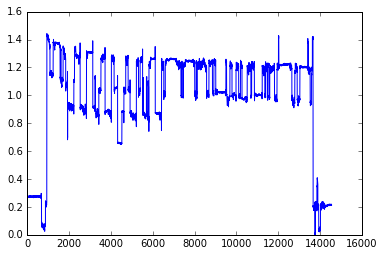

In [24]:
plt.plot(M)

In [25]:
liston=[i for i in range(len(M)) if M[i]>0.5]
liston[0]

936

In [26]:
def model(x,a,b,c,d):
    if x<a:
        return b
    elif x<c:
        return b+(x-a)*d
    else:
        return (c-a)*d+b

In [27]:
Ms=M[range(liston[0]-8,liston[0]+8)]-M[liston[0]-8]

In [28]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))])   

In [29]:
liston[0]-8

928

In [30]:
res = scipy.optimize.minimize(Sq,x0=[7,0.001,9,0.6])

In [31]:
res

      fun: memmap([ 0.12662485], dtype=float32)
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([ 0.,  0.,  0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([  7.00000000e+00,   1.00000000e-03,   9.00000000e+00,
         6.00000000e-01])

In [32]:
ON=liston[0]-8+res.x[2]
print(ON)

937.0


In [33]:
ONint=np.int(np.ceil(ON))
print(ONint)

937


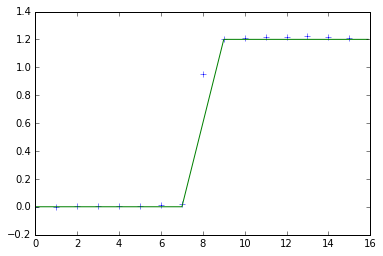

In [34]:
plt.plot(np.squeeze(Ms),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.show()

Model offset and find precise offset time

In [35]:
Ms=M[range(liston[len(liston)-1]-6,liston[len(liston)-1]+6)]

In [36]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))]) 

In [37]:
res = scipy.optimize.minimize(Sq,x0=[5.4,1.4,7,-0.6])

In [39]:
OFF=liston[len(liston)-1]-8+res.x[0]
#OFF=liston[len(liston)-1]
print(OFF)
OFFint=np.int(np.floor(OFF))
print(OFFint)

13656.3897066
13656


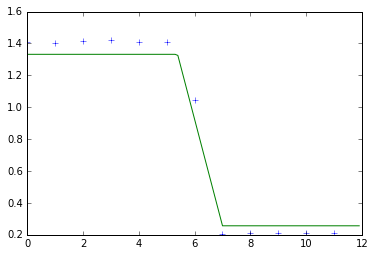

In [40]:
plt.plot(np.squeeze(Ms),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.show()

# Save times were light is on

In imageJ: choose subsack between these 2 values

In [47]:
print(ONint+1)
print(OFFint+1)

938
13657


In [49]:
TimeOn=[Tvid.T[i] for i in range(ONint,(OFFint+1))]

In [52]:
Tinit=(ON-ONint-1)*(Tvid.T[ONint]-Tvid.T[ONint-1])+Tvid.T[ONint-1]

In [53]:
TimeOnFinal=TimeOn-Tinit

In [80]:
Fileout="".join(filename[i] for i in range(len(filename)-4))

In [81]:
OutFilename=Fileout+'FluoOn.mat'

In [82]:
OutFilename

'/media/sophie2/945/945timevideofullFluoOn.mat'

In [84]:
sio.savemat(OutFilename, {'TimeFluoOnVid':TimeOnFinal})